In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("FraudDetection") \
    .getOrCreate()


In [2]:
df = spark.read.csv("/Users/anand/Downloads/transactions_train.csv", header=True, inferSchema=True)

In [3]:
from pyspark.sql.functions import col, expr

df = df.withColumn("errorBalanceOrig", col("oldbalanceOrig") - col("newbalanceOrig") - col("amount")) \
       .withColumn("errorBalanceDest", col("newbalanceDest") - col("oldbalanceDest") - col("amount"))

In [4]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="type", outputCol="typeIndex")
df = indexer.fit(df).transform(df)

In [5]:
from pyspark.ml.feature import VectorAssembler

features = ['step', 'typeIndex', 'amount', 'oldbalanceOrig', 'newbalanceOrig',
            'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest']
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df).select("features", col("isFraud").alias("label"))

In [6]:
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

In [7]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
model = rf.fit(train_df)


In [8]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.transform(test_df)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

roc_auc = evaluator.evaluate(predictions)
print(f"ROC AUC: {roc_auc:.3f}")

ROC AUC: 0.999


In [9]:
#Optional
import pandas as pd

importances = model.featureImportances.toArray()
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)


# Exploratory Data Analysis (EDA)

+-------+------------------+-----------------+-----------------+--------------------+
|summary|            amount|   oldbalanceOrig|   newbalanceOrig|             isFraud|
+-------+------------------+-----------------+-----------------+--------------------+
|  count|           6351193|          6351193|          6351193|             6351193|
|   mean|179815.53596357084|834795.6840372103|856169.5828314417|0.001215047314732...|
| stddev| 603630.9774416792|2889959.094210196|2926073.059621181|   0.034836348342406|
|    min|               0.0|              0.0|              0.0|                   0|
|    max|     9.244551664E7|    5.958504037E7|    4.958504037E7|                   1|
+-------+------------------+-----------------+-----------------+--------------------+



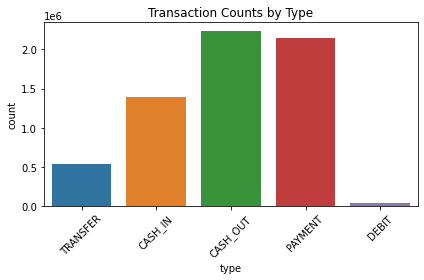

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt

# Start Spark session
spark = SparkSession.builder.appName("FraudEDA").getOrCreate()

# Load data
df = spark.read.csv("/Users/anand/Downloads/transactions_train.csv", header=True, inferSchema=True)

# Feature engineering
df = df.withColumn("errorBalanceOrig", col("oldbalanceOrig") - col("newbalanceOrig") - col("amount")) \
       .withColumn("errorBalanceDest", col("newbalanceDest") - col("oldbalanceDest") - col("amount"))

# Summary statistics
df.describe(["amount", "oldbalanceOrig", "newbalanceOrig", "isFraud"]).show()

# Visualization A: Transaction type counts
type_counts = df.groupBy("type").count().toPandas()
sns.barplot(data=type_counts, x="type", y="count")
plt.title("Transaction Counts by Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




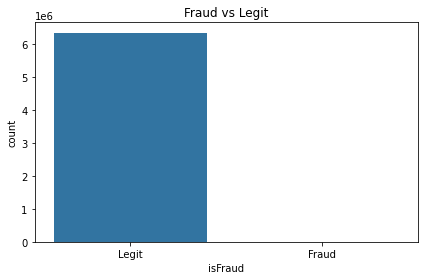

In [12]:
# Visualization B: Fraud vs Legit
fraud_counts = df.groupBy("isFraud").count().toPandas()
sns.barplot(data=fraud_counts, x="isFraud", y="count")
plt.title("Fraud vs Legit")
plt.xticks([0, 1], ["Legit", "Fraud"])
plt.tight_layout()
plt.show()

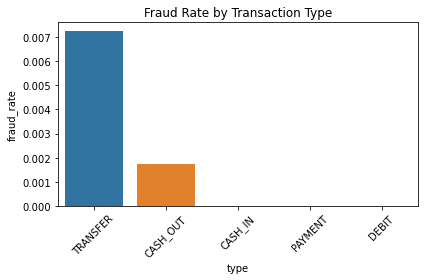

In [13]:
# Visualization C: Fraud Rate by Transaction Type
fraud_rate = df.groupBy("type").agg({"isFraud": "avg"}).withColumnRenamed("avg(isFraud)", "fraud_rate")
fraud_rate_pd = fraud_rate.toPandas().sort_values("fraud_rate", ascending=False)
sns.barplot(data=fraud_rate_pd, x="type", y="fraud_rate")
plt.title("Fraud Rate by Transaction Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

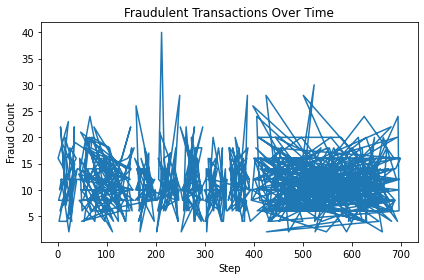

In [14]:
# Visualization D: Fraud over time steps
fraud_over_time = df.filter(col("isFraud") == 1).groupBy("step").count().toPandas()
plt.plot(fraud_over_time["step"], fraud_over_time["count"])
plt.title("Fraudulent Transactions Over Time")
plt.xlabel("Step")
plt.ylabel("Fraud Count")
plt.tight_layout()
plt.show()